# Simple regression with Pytorch v2

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from notebooks.pytorch.simple_regression import SimpleRegression

%matplotlib inline
plt.style.use('fivethirtyeight')

## Data generation

In [53]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (.1 * np.random.randn(N, 1))

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


## Data Preparation v2

In [54]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)


# Model configuration v4 

In [55]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

In [56]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]]), '0.bias': tensor([0.8300])})


## Model Training

In [57]:
sbs = SimpleRegression(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')
print(sbs.model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [58]:
sbs.train(n_epochs=200)
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

OrderedDict({'0.weight': tensor([[1.9416]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})
200


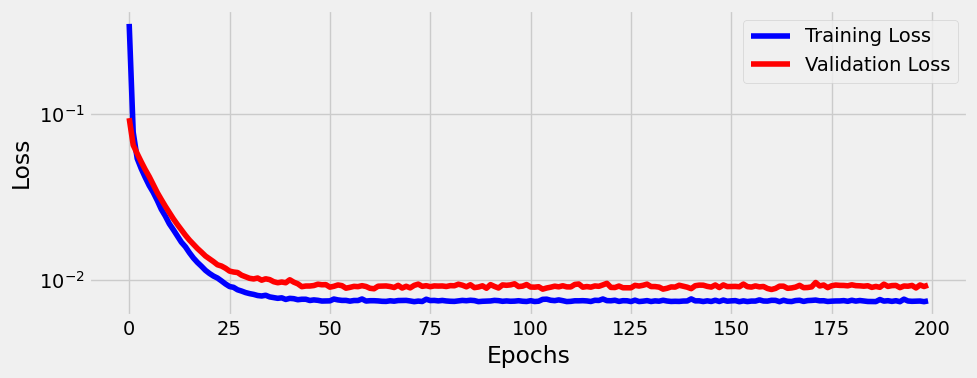

In [59]:
fig = sbs.plot_losses()

## Making Predictions

In [60]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
predictions = sbs.predict(new_data)
predictions


array([[1.9942763],
       [1.605955 ],
       [2.3825977]], dtype=float32)

## Checkpointing

In [61]:
sbs.save_checkpoint('model_checkpoint.pth')

In [62]:
new_sbs = SimpleRegression(model, loss_fn, optimizer)
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9416]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})


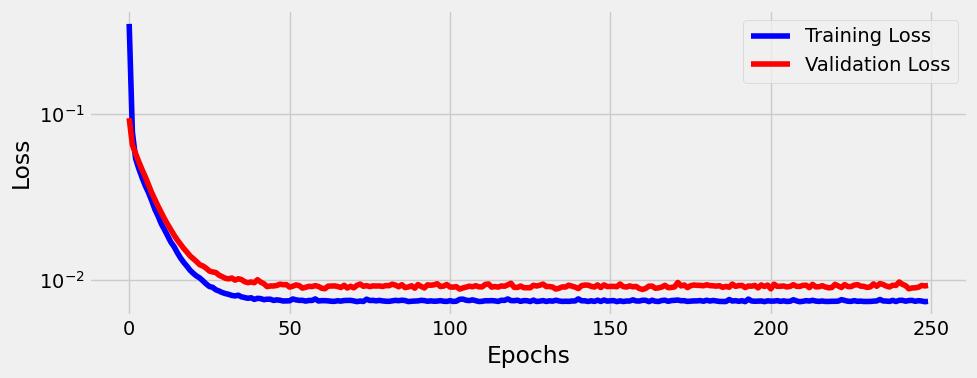

In [63]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)
fig = new_sbs.plot_losses()

In [64]:
print(sbs.model.state_dict())

OrderedDict({'0.weight': tensor([[1.9419]], device='cuda:0'), '0.bias': tensor([1.0241], device='cuda:0')})
